In [3]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from qibo import hamiltonians, set_backend
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketScheduling, DoubleBracketIteration, DoubleBracketCostFunction
from qibo.models.dbi.utils import *
from qibo.models.dbi.utils_scheduling import *

### Normalization of D

In [2]:
# Hamiltonian
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 7
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCostFunction.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)

[Qibo 0.2.5|INFO|2024-03-21 14:14:06]: Using qibojit (numba) backend on /CPU:0


In [39]:
factor = np.array([1,2**nqubits])
s_space = np.linspace(1e-5, 1.0, 100)
off_diagonal_norm_diff = np.empty((len(factor)+1,len(s_space)))
potential = np.empty((len(factor)+1,len(s_space)))
for i in range(len(factor)):
# generate data for plotting sigma decrease of the first step
    d = np.diag(np.linspace(1,2**nqubits,2**nqubits))/factor[i]
    for s in range(len(s_space)):
        dbi_eval = deepcopy(dbi)
        dbi_eval(s_space[s],d=d)
        off_diagonal_norm_diff[i,s] = (dbi_eval.off_diagonal_norm - dbi.off_diagonal_norm)
        potential[i,s] = dbi_eval.least_squares(D=d)
    """
    # grid_search
    step_grid = dbi.choose_step(scheduling=DoubleBracketScheduling.grid_search,d=d)
    print('grid_search step:', step_grid)
    # hyperopt
    step_hyperopt = dbi.choose_step(scheduling=DoubleBracketScheduling.hyperopt,d=d, max_evals=100, step_max=0.6)
    print('hyperopt_search step:', step_hyperopt)
    # polynomial
    step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d, n=3)
    print('polynomial_approximation step:', step_poly)
    """
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
step = 1e-2
iterations = 200
d, loss, grad, diags = gradient_ascent(dbi, d,step, iterations)
for s in range(len(s_space)):
        dbi_eval = deepcopy(dbi)
        dbi_eval(s_space[s],d=d)
        off_diagonal_norm_diff[2,s] = (dbi_eval.off_diagonal_norm - dbi.off_diagonal_norm)
        potential[2,s] = dbi_eval.least_squares(D=d)


Text(0, 0.5, 'Least squares cost function')

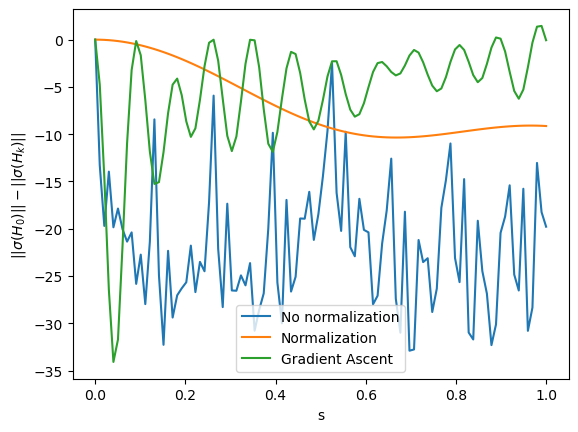

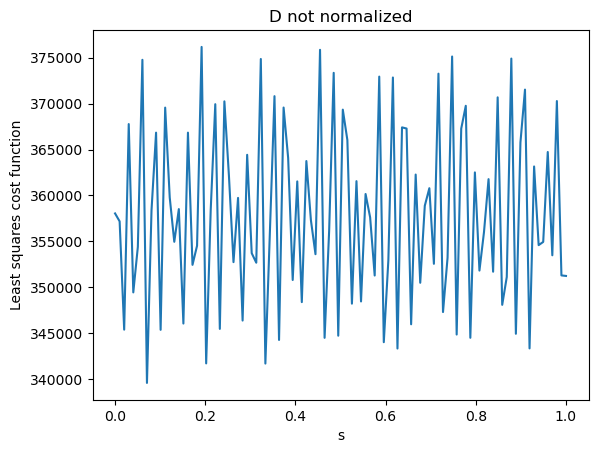

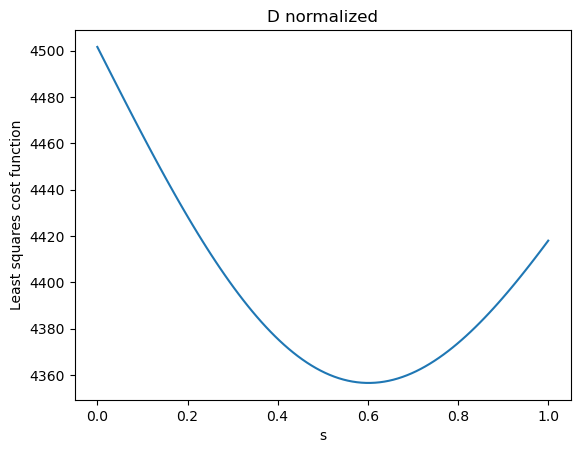

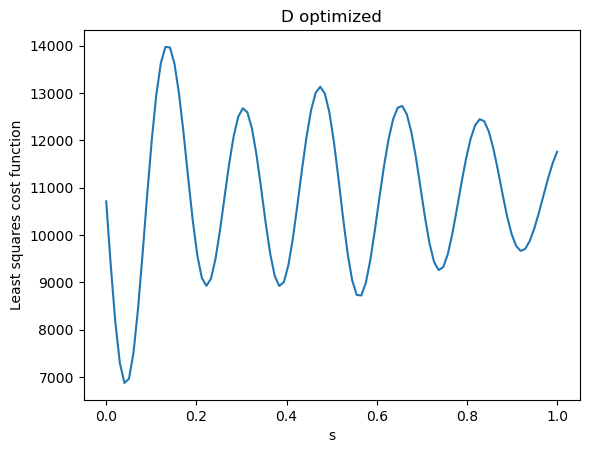

In [40]:
# Plot the results
plt.figure()
plt.plot(s_space, off_diagonal_norm_diff[0,:],label= 'No normalization')
plt.plot(s_space, off_diagonal_norm_diff[1,:],label= 'Normalization')
plt.plot(s_space, off_diagonal_norm_diff[2,:],label= 'Gradient Ascent')
plt.xlabel('s')
plt.ylabel(r'$||\sigma(H_0)||-||\sigma(H_k)||$')
plt.legend()

plt.figure()
plt.title('D not normalized')
plt.plot(s_space, potential[0,:],label= 'No normalization')
plt.xlabel('s')
plt.ylabel('Least squares cost function')

plt.figure()
plt.title('D normalized')
plt.plot(s_space, potential[1,:],label= 'Normalization')
plt.xlabel('s')
plt.ylabel('Least squares cost function')

plt.figure()
plt.title('D optimized')
plt.plot(s_space, potential[2,:],label= 'Gradient Ascent')
plt.xlabel('s')
plt.ylabel('Least squares cost function')

In [94]:
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
dbi_eval = deepcopy(dbi)
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
flows = 50
off_diagonal_norm = np.empty((flows+1,3))
off_diagonal_norm[0,:] = dbi_eval.off_diagonal_norm
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
    dbi_eval(step_poly,d=d)
    off_diagonal_norm[i+1,0] = dbi_eval.off_diagonal_norm


d = np.diag(np.linspace(1,2**nqubits,2**nqubits))/2**nqubits
dbi_eval = deepcopy(dbi)
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
    dbi_eval(step_poly,d=d)
    off_diagonal_norm[i+1,1] = dbi_eval.off_diagonal_norm

dbi_eval = deepcopy(dbi)
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
step = 1e-2
iterations = 200
d, loss, grad, diags = gradient_ascent(dbi_eval, d,step, iterations)
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
    dbi_eval(step_poly,d=d)
    off_diagonal_norm[i+1,2] = dbi_eval.off_diagonal_norm


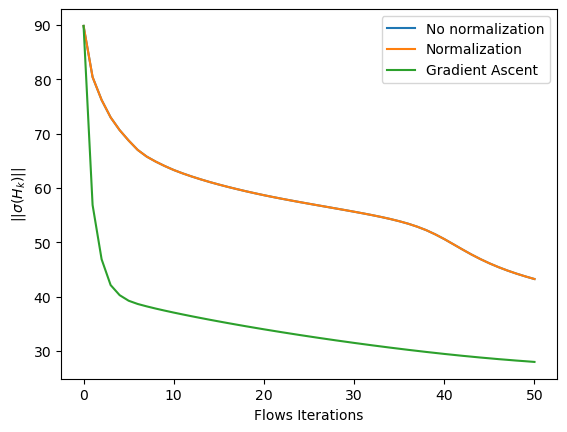

In [95]:
plt.figure()
plt.plot(off_diagonal_norm[:,0],label= 'No normalization')
plt.plot(off_diagonal_norm[:,1],label= 'Normalization')
plt.plot(off_diagonal_norm[:,2],label= 'Gradient Ascent')
plt.xlabel('Flows Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()

### Hyperopt does it get stuck

In [77]:
# Hamiltonian
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 7
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCostFunction.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)

[Qibo 0.2.5|INFO|2024-03-21 15:05:50]: Using qibojit (numba) backend on /CPU:0


In [80]:
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
dbi_eval = deepcopy(dbi)
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
flows = 50
off_diagonal_norm = np.empty(flows+1)
off_diagonal_norm[0] = dbi_eval.off_diagonal_norm
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.hyperopt,d=d)
    dbi_eval(step_poly,d=d)
    off_diagonal_norm[i+1] = dbi_eval.off_diagonal_norm


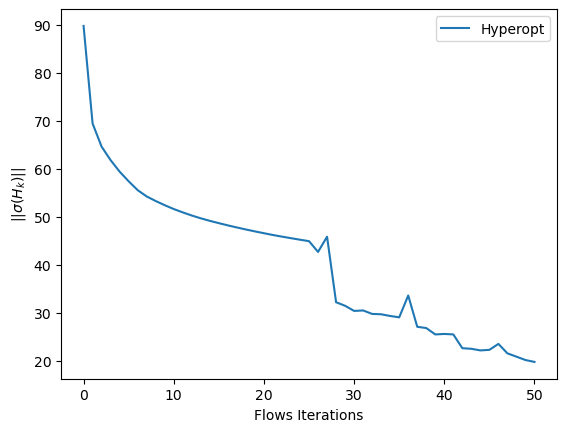

In [81]:
plt.figure()
plt.plot(off_diagonal_norm[:],label= 'Hyperopt')
plt.xlabel('Flows Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()

### Difference between numerical gradients and analytic ones


In [24]:
# Hamiltonian
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 7
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCostFunction.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)

[Qibo 0.2.5|INFO|2024-03-21 14:20:15]: Using qibojit (numba) backend on /CPU:0


In [35]:
nqubits = [3,4,5,6,7]
iterations = 100
step = 1e-2
differences = np.empty((len(nqubits),iterations+1))
loss_max = np.empty(len(nqubits))
for q in range(len(nqubits)):
    # define the hamiltonian
    H_TFIM = hamiltonians.TFIM(nqubits=nqubits[q], h=h)

    # define the least-squares cost function
    cost = DoubleBracketCostFunction.least_squares
    # initialize class
    dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
    loss_max [q] = dbi.least_squares(D=np.diag(np.linspace(1,2**nqubits[q],2**nqubits[q])))
    d = np.diag(np.linspace(1,2**nqubits[q],2**nqubits[q]))
    d_analytic, loss_analytic, grad_analytic, diags_analytic = gradient_ascent(dbi, d,step, iterations)
    d = np.diag(np.linspace(1,2**nqubits[q],2**nqubits[q]))
    d_numerical, loss_numerical, grad_numerical, diags_numerical = gradient_ascent(dbi, d,step, iterations, analytic=False)
    differences[q,:] = loss_analytic - loss_numerical


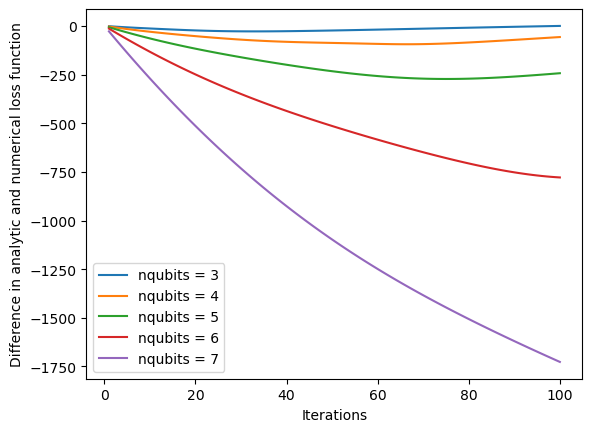

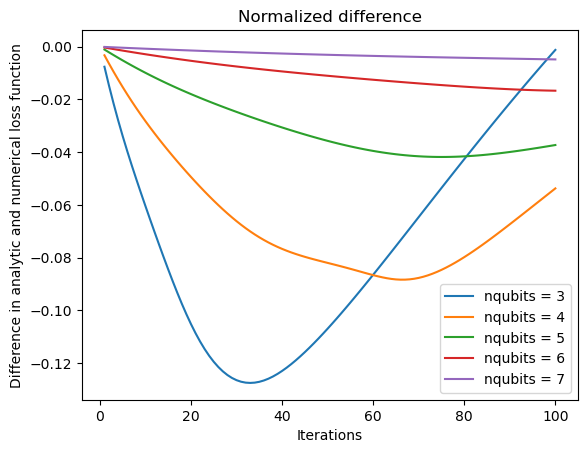

In [40]:
plt.figure()
for q in range(len(nqubits)):
    plt.plot(differences[q,:],label= 'nqubits = {}'.format(nqubits[q]))
plt.xlabel('Iterations')
plt.ylabel('Difference in analytic and numerical loss function')
plt.legend()

plt.figure()
plt.title('Normalized difference')
for q in range(len(nqubits)):
    plt.plot(differences[q,:]/loss_max[q],label= 'nqubits = {}'.format(nqubits[q]))
plt.xlabel('Iterations')
plt.ylabel('Difference in analytic and numerical loss function')
plt.legend()


### Difference in optimization moments


In [49]:
# Hamiltonian
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 7
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCostFunction.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)


[Qibo 0.2.5|INFO|2024-03-21 14:44:56]: Using qibojit (numba) backend on /CPU:0


In [54]:
dbi_eval = deepcopy(dbi)
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
step = 1e-2
iterations = 100




In [75]:
flows = 100
dbi_eval = deepcopy(dbi)
dbi_eval2 = deepcopy(dbi)
d_not_optimized = np.diag(np.linspace(1,2**nqubits,2**nqubits))
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
step = 1e-2
iterations = 100
d_optimized, loss, grad, diags = gradient_ascent(dbi_eval, d,step, iterations,analytic=False)
off_diagonal_norm = np.empty((flows+1,3))
off_diagonal_norm[0] = dbi_eval.off_diagonal_norm
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
    dbi_eval(step_poly,d=d)
    step_poly = dbi_eval2.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_not_optimized)
    dbi_eval2(step_poly,d=d_not_optimized)
    off_diagonal_norm[i+1,0] = dbi_eval.off_diagonal_norm
    off_diagonal_norm[i+1,1] = dbi_eval2.off_diagonal_norm

dbi_eval3 = deepcopy(dbi)
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
for i in range(flows):
    d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
    d_opt, loss, grad, diags = gradient_ascent(dbi_eval3, d,step, 20,analytic=False)
    step_poly = dbi_eval3.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_opt)
    dbi_eval3(step_poly,d=d_opt)
    off_diagonal_norm[i+1,2] = dbi_eval3.off_diagonal_norm   

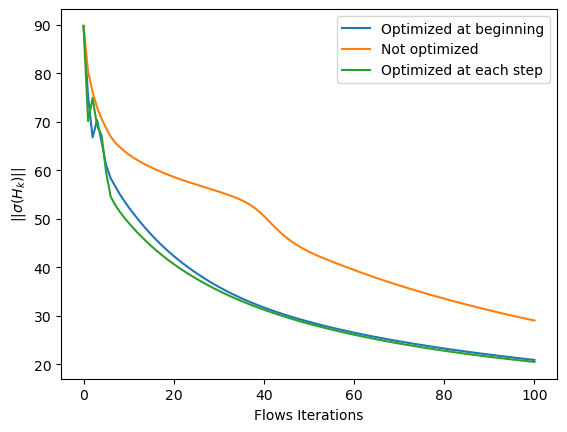

In [76]:
plt.figure()
plt.plot(off_diagonal_norm[:,0],label= 'Optimized at beginning')
plt.plot(off_diagonal_norm[:,1],label= 'Not optimized')
plt.plot(off_diagonal_norm[:,2],label= 'Optimized at each step')
plt.xlabel('Flows Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()


In [4]:
# Hamiltonian
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 7
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCostFunction.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)

[Qibo 0.2.5|INFO|2024-03-21 16:37:52]: Using qibojit (numba) backend on /CPU:0


In [6]:
end = np.linspace(1.1,10*2**nqubits,100)
loss = np.empty(100)
spacing = np.empty(100)
for i in range(100):
    dbi_eval = deepcopy(dbi)
    d = np.diag(np.linspace(1,end[i],2**nqubits))
    spacing[i] = d[1,1] - d[0,0]
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d,n = 3)
    dbi_eval(step_poly,d=d)
    loss[i] = dbi_eval.off_diagonal_norm

Text(0, 0.5, 'Loss function')

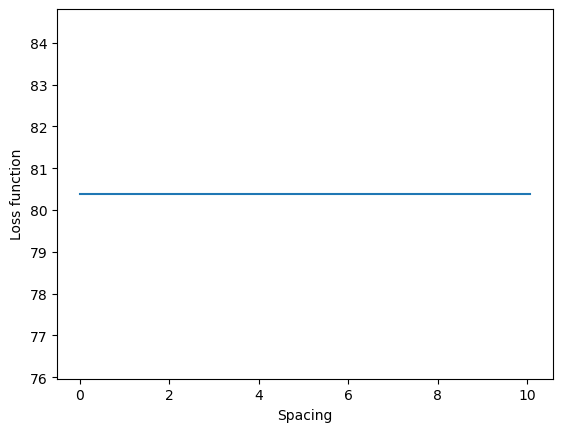

In [7]:
plt.figure()
plt.plot(spacing,loss)
plt.xlabel('Spacing')
plt.ylabel('Loss function')


In [9]:
def d_poly_spacing(nqubits,degree):
    d = np.empty(2**nqubits)
    for i in range(len(d)):
        d[i] = 1 + i**degree
    return np.diag(d)


In [24]:
degrees = np.linspace(0.1,5,100)
nqubits = [3,4,5,7]
h = 3.0

loss = np.empty((100,len(nqubits)))
best_degree = np.empty(len(nqubits))
for q in range(len(nqubits)):
    H_TFIM = hamiltonians.TFIM(nqubits=nqubits[q], h=h)
    dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
    for i in range(100):
        dbi_eval = deepcopy(dbi)
        d = d_poly_spacing(nqubits[q],degrees[i])
        step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d,n = 3)
        dbi_eval(step_poly,d=d)
        loss[i,q] = dbi_eval.off_diagonal_norm
    best_degree[q] = degrees[np.argmin(loss[:,q])]


[1.18888889 1.13939394 1.13939394 1.13939394]


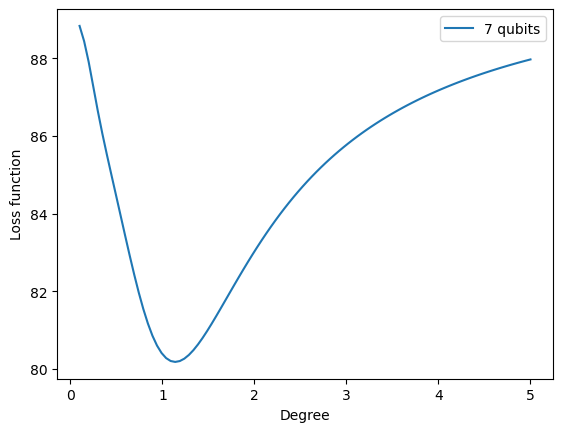

In [26]:
plt.figure()
plt.plot(degrees,loss[:,3],label = f'{nqubits[q]} qubits')
plt.xlabel('Degree')
plt.ylabel('Loss function')
plt.legend()
print(best_degree)

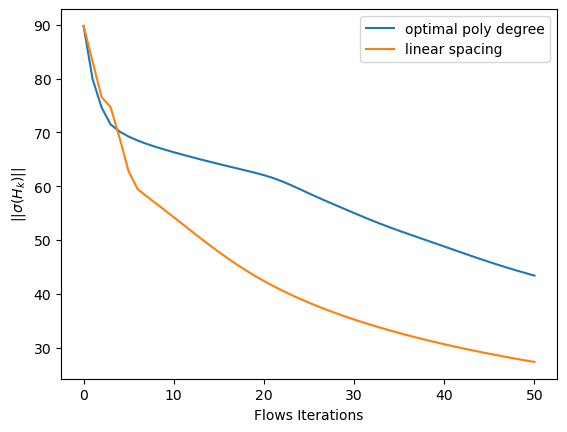

In [32]:
n_qubits = 7
d = d_poly_spacing(n_qubits,best_degree[2])
step = 1e-2
iterations = 50
H_TFIM = hamiltonians.TFIM(nqubits=n_qubits, h=h)
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
d_optimized, loss, grad, diags = gradient_ascent(dbi, d,step, iterations,analytic=False)

flows = 50
off_diagonal_norm = np.empty((flows+1,2))
off_diagonal_norm[0,:] = dbi.off_diagonal_norm
for i in range(flows):
    step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_optimized)
    dbi(step_poly,d=d_optimized)
    off_diagonal_norm[i+1,0] = dbi.off_diagonal_norm

d = d_poly_spacing(n_qubits,1)
dbi2 = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
d_optimized, loss, grad, diags = gradient_ascent(dbi2, d,step, iterations,analytic=False)
for i in range(flows):
    step_poly = dbi2.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_optimized)
    dbi2(step_poly,d=d_optimized)
    off_diagonal_norm[i+1,1] = dbi2.off_diagonal_norm

plt.figure()
plt.plot(off_diagonal_norm[:,0],label= 'optimal poly degree')
plt.plot(off_diagonal_norm[:,1],label= 'linear spacing')
plt.xlabel('Flows Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()



In [103]:
def delta_to_d(delta):
    d = np.empty(len(delta))
    d[0] = 0
    for i in range(len(d)-1):
        d[i+1] = d[i] + delta[i]
    return np.diag(d)

def d_to_delta(d):
    delta = np.empty(len(d)-1)
    for i in range(len(d)-1):
        delta[i] = d[i+1,i+1]-d[i,i]
    return delta

def polynomial(x,degree,coefficients):
    y = np.empty(len(x))
    for i in range(degree):
        y += coefficients[i]*x**i
    return y

def gradient_delta_polynomial(dbi, degree, coefficients,h=1e-5):
    grad = np.empty(degree)
    dim = dbi.h.matrix.shape[0]
    delta = polynomial(np.linspace(0,1,dim),degree,coefficients)
    d = delta_to_d(delta)
    dbi_eval = deepcopy(dbi)
    angle = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
    dbi_eval(angle,d=d)
    norm = dbi_eval.off_diagonal_norm
    for i in range(len(grad)):
        new_coeff = np.copy(coefficients)
        new_coeff[i] += h
        new_delta = polynomial(np.linspace(0,1,dim),degree,new_coeff)
        new_d = delta_to_d(new_delta)
        dbi_eval = deepcopy(dbi)
        angle = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=new_d)
        dbi_eval(angle,d=new_d)
        new_norm = dbi_eval.off_diagonal_norm
        grad[i] = (new_norm-norm)/h

    return grad


def optimize_poly(dbi, step, iterations, degree):
    coefficients = np.random.rand(degree)
    dim = dbi.h.matrix.shape[0]
    delta = polynomial(np.linspace(0,1,dim),degree,coefficients)
    d = delta_to_d(delta)
    loss = np.empty(iterations)
    grad = np.empty(degree)
    for i in range(iterations):
        dbi_eval = deepcopy(dbi)
        step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
        dbi_eval(step_poly,d=d)
        loss[i] = dbi_eval.off_diagonal_norm
        grad = gradient_delta_polynomial(dbi_eval, degree, coefficients)
        coefficients -= step*grad
        delta = polynomial(np.linspace(0,1,dim),degree,coefficients)
        d = delta_to_d(delta)
    return coefficients, loss, grad



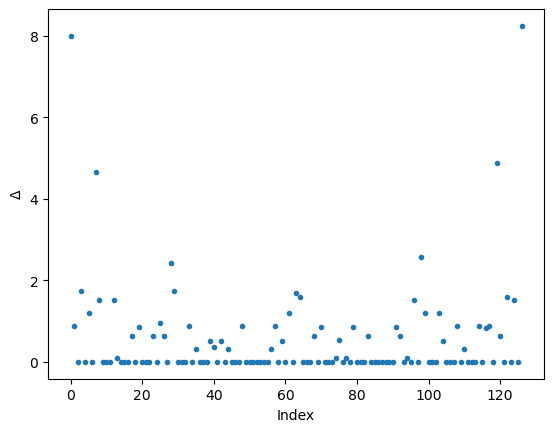

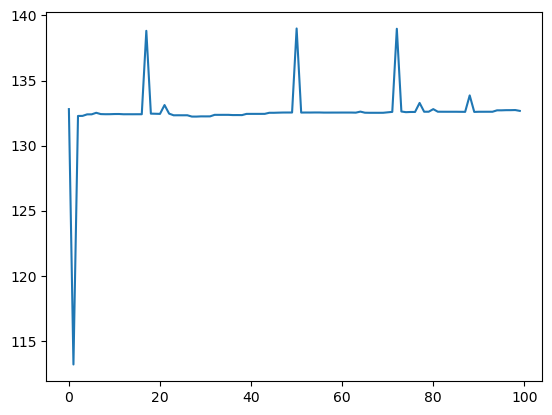

In [106]:
H_TFIM = hamiltonians.TFIM(nqubits=7, h=5.0)
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
matrix = dbi.h.matrix
eigenenergies = np.diag(np.linalg.eigh(matrix)[0])
delta = d_to_delta(eigenenergies)

plt.figure()
plt.plot(delta,'.')
plt.xlabel('Index')
plt.ylabel(r'$\Delta$')

d, loss, grad = optimize_poly(dbi, 1e-3, 100, 3)
plt.figure()
plt.plot(loss)
